Lets retrive the dataset from cleaned schema first.

In [38]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt



In [2]:
host = r'127.0.0.1' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'1234' 
port = r'5433' 
schema = r'cleaned'

In [3]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [6]:
schema = "Cleaned"  
table_name = "HeartDisease"  

sql = f'SELECT * FROM "{schema}"."{table_name}"'

data = pd.read_sql(sql, db_conn, index_col=None)
print(data.head())  

   age  sex  cp trestbps  chol fbs restecg thalach exang  oldpeak slope thal   
0   32    1   1       95     0   0       0     127     0      0.7     1    7  \
1   36    1   4      110     0   0       0     125     1      1.0     2    6   
2   38    0   4      105     0   0       0     166     0      2.8     1    7   
3   38    0   4      110     0   0       0     156     0      0.0     2    3   
4   38    1   3      100     0   0       0     179     0     -1.1     1    7   

   num  
0    1  
1    1  
2    2  
3    1  
4    0  


In [8]:
df = data.copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       238 non-null    int64  
 1   sex       238 non-null    int64  
 2   cp        238 non-null    int64  
 3   trestbps  238 non-null    object 
 4   chol      238 non-null    int64  
 5   fbs       238 non-null    object 
 6   restecg   238 non-null    object 
 7   thalach   238 non-null    object 
 8   exang     238 non-null    object 
 9   oldpeak   238 non-null    float64
 10  slope     238 non-null    object 
 11  thal      238 non-null    object 
 12  num       238 non-null    int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 24.3+ KB


## Analytical Question:
Can we accurately predict the presence of heart disease based on patient attributes, and which features contribute most to the prediction?


## Feature Engineering
Since, I have very less knowledge of parameters contained by my dataset and I am less familiar with Medical field, I searched and found some factors that can be calculated from the features that my dataset contains. And, i guess this is a better way to find accurate result than randomly finding ratio of any features.

Some of the features I found are:
1. Blood Pressure & Cholesterol Interaction (bp_chol_ratio)
    Reason to use: Combines blood pressure and cholesterol to capture their joint effect on heart disease risk. High values indicate increased cardiovascular stress.

2. Heart Rate Reserve (heart_rate_reserve)
    Reason to use: Measures the difference between maximum and resting heart rate, indicating heart fitness. A lower reserve suggests a higher risk of heart disease.

3. ST Slope & Oldpeak Interaction (slope_oldpeak_product)
    Reason to use: Combines ST slope and oldpeak (ST depression) to assess ischemia. Higher values suggest severe heart strain and greater heart disease risk.

4. Exercise Stress Impact (stress_impact)
    Reason to use: Measures heart performance under stress (exercise). Poor performance can indicate underlying cardiovascular issues, helping predict heart disease.

These features are not my personal calculation, I found these on many articles and I choose some that I found more relevant.
Hence, these feature are derived by domain experts.


In [11]:
df['trestbps'] = pd.to_numeric(df['trestbps'])
df['thalach'] = pd.to_numeric(df['thalach'])

In [12]:
df["bp_chol_ratio"] = df["trestbps"] / (df["chol"] + 1)

In [13]:
df["heart_rate_reserve"] = 220 - df["age"] - df["thalach"]
df["slope_oldpeak_product"] = df["slope"].astype(float) * df["oldpeak"]
df["stress_impact"] = (df["thalach"] - df["trestbps"]) / (df["oldpeak"] + 1)


In [15]:
X = df.drop(columns=['num'])
y = df['num']

In [16]:
X = pd.get_dummies(X, drop_first=True)


In [22]:
X = X.fillna(X.mean())


In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred = rf_model.predict(X_test)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8750

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.83      0.90      0.86        21
           2       1.00      0.85      0.92        13
           3       0.78      0.78      0.78         9
           4       1.00      1.00      1.00         1

    accuracy                           0.88        48
   macro avg       0.92      0.91      0.91        48
weighted avg       0.88      0.88      0.88        48


Confusion Matrix:
[[ 4  0  0  0  0]
 [ 0 19  0  2  0]
 [ 0  2 11  0  0]
 [ 0  2  0  7  0]
 [ 0  0  0  0  1]]


Finding important features 

In [28]:
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(features_df)


Feature Importance:
                  Feature  Importance
8      heart_rate_reserve    0.130238
0                     age    0.125214
10          stress_impact    0.121310
5                 thalach    0.115585
7           bp_chol_ratio    0.089160
3                trestbps    0.088547
6                 oldpeak    0.082322
9   slope_oldpeak_product    0.070721
2                      cp    0.034049
15                slope_2    0.020940
14                exang_1    0.020623
12              restecg_1    0.020210
18                 thal_7    0.019830
17                 thal_6    0.016221
11                  fbs_1    0.014141
16                slope_3    0.011786
1                     sex    0.010751
13              restecg_2    0.008354
4                    chol    0.000000


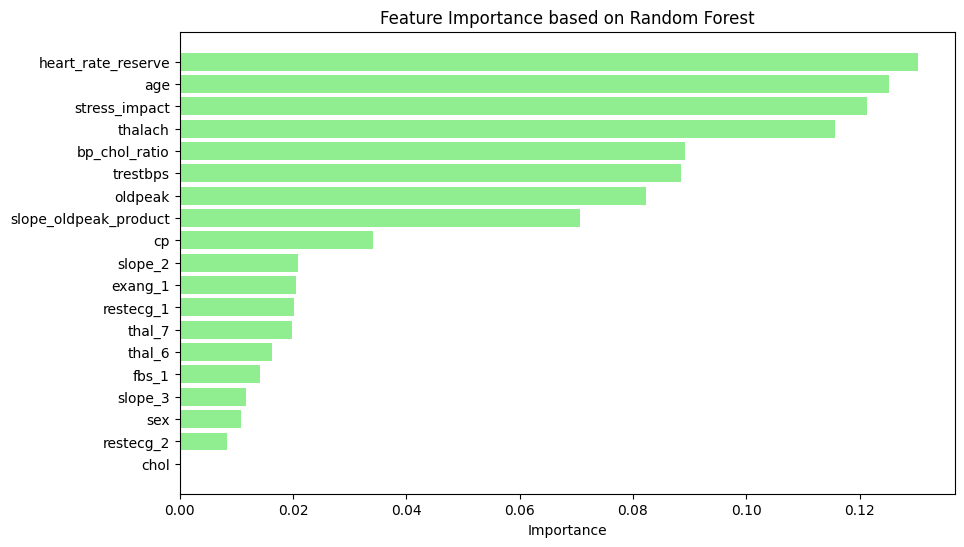

In [40]:
# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Feature Importance based on Random Forest')
plt.gca().invert_yaxis()  # Display the highest importance at the top
plt.show()

Lets find another way of finding importance feature

I'm using Mutual Information (MI) to find important feature. Higher MI indicates that a feature is more informative in predicting the target.

In [36]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information between features and target variable
mutual_info = mutual_info_classif(X_train, y_train)

# Create a DataFrame to show MI values
mi_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mutual_info
})

# Sort by MI in descending order
mi_importance_df = mi_importance_df.sort_values(by='Mutual Information', ascending=False)

print("\nMutual Information Feature Importance:")
print(mi_importance_df)



Mutual Information Feature Importance:
                  Feature  Mutual Information
10          stress_impact            0.303028
8      heart_rate_reserve            0.246533
5                 thalach            0.229261
4                    chol            0.146973
6                 oldpeak            0.132126
17                 thal_6            0.110559
9   slope_oldpeak_product            0.110445
1                     sex            0.108314
0                     age            0.104454
7           bp_chol_ratio            0.098718
3                trestbps            0.098270
16                slope_3            0.060963
2                      cp            0.045774
18                 thal_7            0.041533
15                slope_2            0.025800
11                  fbs_1            0.016924
12              restecg_1            0.000000
13              restecg_2            0.000000
14                exang_1            0.000000


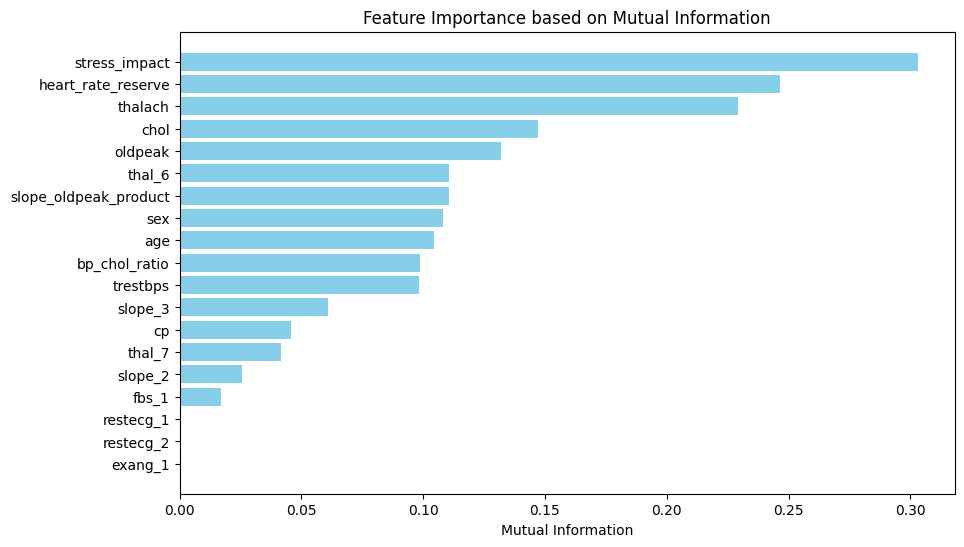

In [39]:
plt.figure(figsize=(10, 6))
plt.barh(mi_importance_df['Feature'], mi_importance_df['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.title('Feature Importance based on Mutual Information')
plt.gca().invert_yaxis()  # To display the highest MI at the top
plt.show()

## Summary:



The goal of this analysis was to predict the presence of heart disease based on patient attributes, specifically exploring how features like heart_rate_reserve, stress_impact, and bp_chol_ratio contribute to the prediction. I used Random forest classifier algorithm for the classification and used both model based and Mutual Information based methods to find the important features. From both methods, it was found that features like heart_rate_reserve, thalach, oldpeak, stress_impact were key predictors of heart disease. Also, the model achieved an accuracy of 87.5% and overall performance was good as well. Since, the dataset was small and there was an issue of class imbalance, as there were less data with num value equal to 4, which may impact the overall performance. Also,there was some redundancy in feature like thalach and heart_rate_reserve as both were derived from heart rate and both had almost equal contribution in prediction. To sum up, we can further more refine feature to get more better result.